In [1]:
# https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings


# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/

data_dir = '/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio) (V2))/'

Mounted at /content/gdrive
/content/gdrive/My Drive


In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.7.0


In [3]:
model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=(100, 100, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(6,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [5]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [7]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio) (V2))/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio) (V2))/"+img)))
    for i in path:
        image = cv2.imread("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio) (V2))/"+img+'/'+i)
        image = cv2.resize(image, (100,100))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']


In [8]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [9]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(956, 100, 100, 3) (638, 100, 100, 3)


In [10]:
jac = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

#datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


#datagen.fit(xtrain)
# Fits-the-model
history = model.fit(xtrain, ytrain, batch_size=8,
               steps_per_epoch=xtrain.shape[0] //8,
               epochs=30,
               verbose=2,
               callbacks=[jac, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.66134, saving model to model.h5
119/119 - 117s - loss: 1.8035 - accuracy: 0.4674 - val_loss: 0.6613 - val_accuracy: 0.7782 - lr: 0.0010 - 117s/epoch - 986ms/step
Epoch 2/30

Epoch 00002: val_loss improved from 0.66134 to 0.48984, saving model to model.h5
119/119 - 92s - loss: 1.0799 - accuracy: 0.6340 - val_loss: 0.4898 - val_accuracy: 0.8410 - lr: 0.0010 - 92s/epoch - 776ms/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.48984 to 0.37293, saving model to model.h5
119/119 - 94s - loss: 1.0207 - accuracy: 0.6424 - val_loss: 0.3729 - val_accuracy: 0.8682 - lr: 0.0010 - 94s/epoch - 792ms/step
Epoch 4/30

Epoch 00004: val_loss improved from 0.37293 to 0.30255, saving model to model.h5
119/119 - 93s - loss: 0.9374 - accuracy: 0.6983 - val_loss: 0.3026 - val_accuracy: 0.8933 - lr: 0.0010 - 93s/epoch - 784ms/step
Epoch 5/30

Epoch 00005: val_loss improved from 0.30255 to 0.29372, saving model to model.h5
119/119 - 93s - loss: 0.8

In [11]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 638 	accurately-predicted-data: 482 	 wrongly-predicted-data:  156
Accuracy: 75.549 %


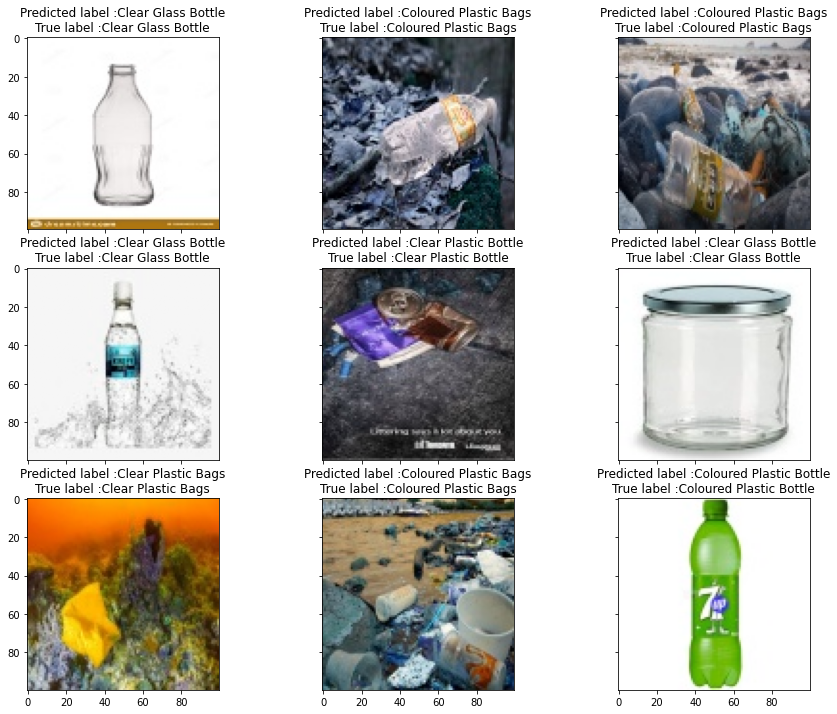

In [12]:
label=['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

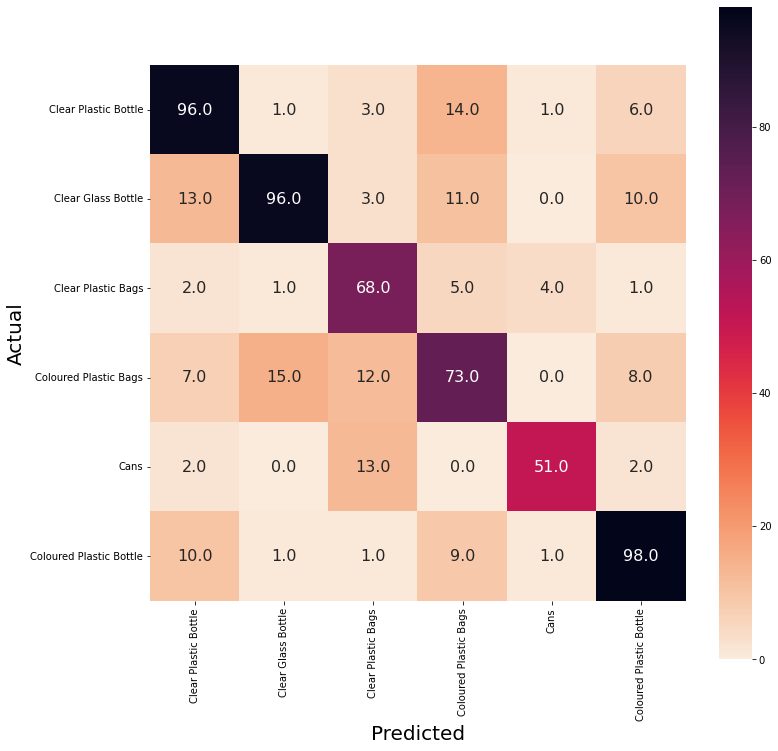

In [13]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [14]:
from sklearn.metrics import classification_report, log_loss, accuracy_score

y_pred=model.predict(xtest)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(ytest,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       121
           1       0.84      0.72      0.78       133
           2       0.68      0.84      0.75        81
           3       0.65      0.63      0.64       115
           4       0.89      0.75      0.82        68
           5       0.78      0.82      0.80       120

    accuracy                           0.76       638
   macro avg       0.77      0.76      0.76       638
weighted avg       0.76      0.76      0.76       638



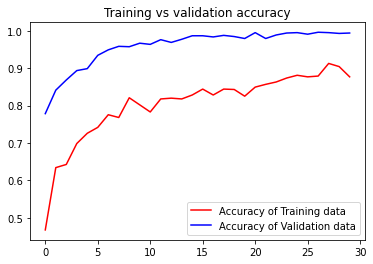

<Figure size 432x288 with 0 Axes>

In [15]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

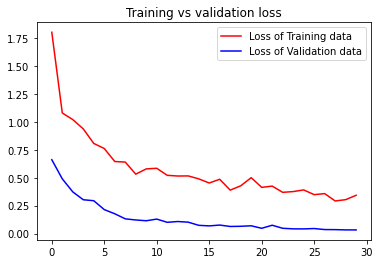

<Figure size 432x288 with 0 Axes>

In [16]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()